In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
plt.style.use('ggplot')

pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', 50)
%matplotlib inline

# Questions to ask

## Popularity

* How do we define if a game is popular?

* What kind of game is popular on switch?

* Which developer's game is the most popular?

* What is the distribution of the release date? Does it have a relationship with games' popularity?



## Success

* How do we define if a game is successful?

* What kind of game is successful on switch?

* Which developer's game is the most successful?

* What is the distribution of the release date? Does it have a relationship with games' success?

## Online Service

* Nitendo has a paid online service for people to play games together through internet, which game that has this features is the most popular? Is the games which have this feature more popular than those which do not?

* How to make more people pay for the online service?


## Different Platform makes a differece?

* Some games are transfer from other platform such as PS4 and Wii, how is their ratings compared to games that only at switch?

## Selling Data vs scores a game is successful or not

* We have best selling game data , is there any difference between the ranking in Metacritic website? Why?

* What is the relationship between the selling unit and scores in metacritic website?

# Import Dataset

In [2]:
df = pd.read_csv('switchgame.csv')
# df_1 = pd.read_csv('data/switchgame_10.csv')
# df_2 = pd.read_csv('data/switchgame_11.csv')

In [3]:
df.shape

(4150, 14)

We have 4150 observations here.

In [4]:
df.columns

Index(['Rating', 'critic_review_attitude', 'critic_review_count', 'developer',
       'genre', 'meta_score', 'name', 'num_of_player', 'other_platform',
       'rating_count', 'release_date', 'user_score', 'users_review_attitude',
       'users_review_count'],
      dtype='object')

In [5]:
df.dtypes

Rating                     object
critic_review_attitude     object
critic_review_count         int64
developer                  object
genre                      object
meta_score                float64
name                       object
num_of_player              object
other_platform             object
rating_count                int64
release_date               object
user_score                float64
users_review_attitude      object
users_review_count          int64
dtype: object

# Data Cleaning

To do the data cleaning, here is something we need to do:

* **Release date transfer**

* **Create Online column**

* **Manipulate meta_score and user_score:** 

* **Handling missing value**

* **Order the columns** 


* **Release date transfer**

Tranfer the release_date to datetime type

In [6]:
# Transfer release_date to datetime type
df['release_date'] = df.release_date.apply(lambda s: datetime.datetime.strptime(s, '%b %d, %Y').strftime('%Y/%m/%d'))
df['release_date'] = pd.to_datetime(df['release_date'])

* **Create Online column and is_on_other_platfrom**

Generate online columns to see if the game can be played online

First let's look at distribution of num_of_palyer's colums

In [7]:
df.num_of_player.value_counts()

No Online Multiplayer    3400
Online Multiplayer        127
Up to 4                   112
2                          73
Up to 8                    69
Up to 6                    22
Up to 10                   15
Up to 16                    9
Up to 12                    9
Up to 3                     6
Up to 22                    3
Up to 64                    3
Up to 5                     2
Up to 32                    1
Massively Multiplayer       1
Up to more than 64          1
Up to 9                     1
Up to 20                    1
Up to 18                    1
Name: num_of_player, dtype: int64

The games with 'No Online Multiplayer' cannot be player online while others can be played online. Next we generate a new columns 'online', which is True if the game can be played online, else False. Drop the num_of_player column.

In [8]:
df['online'] = (df['num_of_player']!='No Online Multiplayer')
df = df.drop(columns = ['num_of_player'])

In [9]:
df.online.value_counts()

False    3400
True      750
Name: online, dtype: int64

In [10]:
df['is_on_other_platform'] = (~df[['other_platform']].isnull())
df = df.drop(columns = ['other_platform'])

* **Manipulate meta_score and user_score**

Filter games which do have neither meta_score nor user_score. For games that have at least one meta_score and user_score, replace missing score with the exsiting score. Normalize two scores and calculate their mean as the average score.

First we want to filter games which do have neither meta_score nor user_score, and normalize them to same scale.

In [11]:
# check how many games have missing value in both meta_score and user_score
mask = df[['meta_score','user_score']].isnull().all(axis = 1)

In [12]:
# Make a dataframe which either meta_score or user_score exist  
df_filter = df.loc[~mask][['name','meta_score','user_score']]
# normalize them to same scale
df_filter['user_score'] = df_filter['user_score']*10

For games that have at least one meta_score and user_score, replace missing score with the exsiting score

In [13]:
for row in df_filter.index:
    if df_filter.loc[[row],'meta_score'].isnull().all(): #check if meta_score is missing
        df_filter.loc[row,'meta_score'] = df_filter.loc[row,'user_score']
    if df_filter.loc[[row],'user_score'].isnull().all(): #check if user_score is missing
        df_filter.loc[row,'user_score'] = df_filter.loc[row,'meta_score']

Now merge df_filter and df 

In [14]:
df = pd.merge(df.drop(['meta_score','user_score'],axis=1),df_filter,how = 'left', on='name')

Take average of the meta_score and user_score as avg_score

In [15]:
df['avg_score'] = (df['meta_score'] + df['user_score'])/2

Calculate total reviews that a game received

In [16]:
df['total_review_counts'] = df['users_review_count'] + df['critic_review_count']

* **Handling Missing Value**

In this dataset, missing value may have lots of meaning. For example, missing value in meta_score means that this game is not so popular that no one cares about it. For this reason we want to keep all missing value first, and when we come to the data analysis part we can do something with them.

For users_attitude and critic_attitude, there should be some missing value such as an empty dictionary, 
0 count for all element in dictionary. We want to convert them to NaN first. 

In [17]:
df = df.replace('{}',np.nan)
df = df.replace("{'Positive': 0, 'Mixed': 0, 'Negative': 0}",np.nan)

Then let's just check how many missing values in each column.

In [18]:
np.sum(df.isnull())

Rating                     776
critic_review_attitude    1264
critic_review_count          0
developer                    0
genre                        0
name                         0
rating_count                 0
release_date                 0
users_review_attitude     2069
users_review_count           0
online                       0
is_on_other_platform         0
meta_score                2227
user_score                2227
avg_score                 2227
total_review_counts          0
dtype: int64

*  **Order columns**

We also want to order the columns so that we have a clearer look at the dataset.

In [19]:
# Order the columns so that we have a clearer look at the dataset.  
columns = ['name','developer','release_date','is_on_other_platform','meta_score','user_score','avg_score','rating_count','genre','Rating',\
           'critic_review_count','users_review_count','total_review_counts','critic_review_attitude','users_review_attitude','online']
df = df[columns]

In [20]:
df.sample(5)

,name,developer,release_date,is_on_other_platform,meta_score,user_score,avg_score,rating_count,genre,Rating,critic_review_count,users_review_count,total_review_counts,critic_review_attitude,users_review_attitude,online
1874,Degrees of Separation,Modus Games,2019-02-14,True,68.0,73.0,70.5,9,"Action,Platformer,2D",E,5,3,8,"{'Positive': 2, 'Mixed': 3, 'Negative': 0}","{'Positive': 1, 'Mixed': 2, 'Negative': 0}",True
1172,Thea: The Awakening,Monster Couch,2019-02-01,True,71.0,72.0,71.5,13,"Strategy,Turn-Based,4X",T,11,1,12,"{'Positive': 4, 'Mixed': 7, 'Negative': 0}","{'Positive': 1, 'Mixed': 0, 'Negative': 0}",False
1495,Zombie Night Terror,Plug In Digital,2019-01-31,True,NaN,NaN,NaN,0,"Puzzle,Action",M,1,0,1,"{'Positive': 0, 'Mixed': 1, 'Negative': 0}",NaN,False
3593,ACA NeoGeo: World Heroes 2 Jet,Hamster,2018-03-22,True,NaN,NaN,NaN,0,"Action,Fighting,2D",T,1,0,1,"{'Positive': 0, 'Mixed': 1, 'Negative': 0}",NaN,False
766,Spheroids,Eclipse Games,2018-07-20,True,NaN,NaN,NaN,0,"Action,Platformer,2D",E,1,1,2,"{'Positive': 0, 'Mixed': 0, 'Negative': 1}","{'Positive': 0, 'Mixed': 1, 'Negative': 0}",False


In [21]:
# Save the clean data into file
df.to_csv('switchgame_clean.csv')

In [22]:
df.shape

(4150, 16)

# Data Analysis

# Data Summary

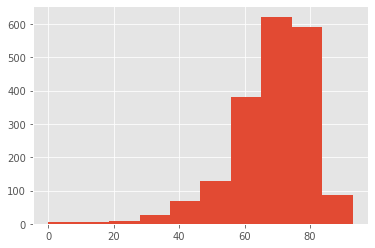

In [23]:
df['avg_score'].hist()

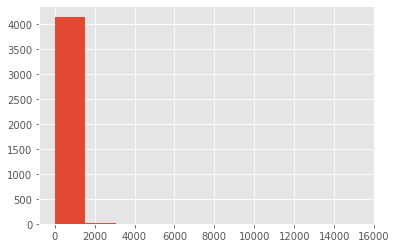

In [24]:
df['rating_count'].hist()

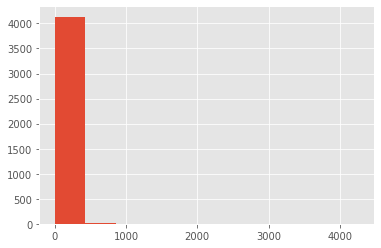

In [25]:
df['total_review_counts'].hist()

## Polularity

### Define popularity

First of all, let's decide how to measure if a game is popular.

* Games that have more ratings
* Games that have more reviews

In [26]:
df.sort_values(by='rating_count',ascending=False).head(10)[['name','rating_count']]

,name,rating_count
1071,The Legend of Zelda: Breath of the Wild,15248
3709,Animal Crossing: New Horizons,5401
900,Super Mario Odyssey,5264
66,Pokemon Sword,5040
3933,Astral Chain,3173
882,Super Smash Bros. Ultimate,2652
67,Pokemon Shield,2646
2346,Fire Emblem: Three Houses,2190
1553,Xenoblade Chronicles 2,1910
2981,Mario Kart 8 Deluxe,1851


In [27]:
df.sort_values(by = 'total_review_counts',ascending = False ).head(10)[['name','total_review_counts']]

,name,total_review_counts
1071,The Legend of Zelda: Breath of the Wild,4270
3709,Animal Crossing: New Horizons,3613
66,Pokemon Sword,2758
3933,Astral Chain,1605
900,Super Mario Odyssey,1537
67,Pokemon Shield,1392
882,Super Smash Bros. Ultimate,1047
2346,Fire Emblem: Three Houses,881
62,"Pokemon: Let's Go, Pikachu!",762
1553,Xenoblade Chronicles 2,645


As we can see, nine games are in top 10 using two criteria. The Legend of Zelda: Breath of the Wild is the most popular game, following Animal Crossing: New Horizons. 

### genre

For the genre, we need to do some tricky way to split the genre.

In [28]:
# Make a copy of the original dataframe
df_genre = df.copy()
# Split the column the column using '|'
df_genre.genre = df_genre.genre.apply(lambda x: x.split(','))
# i keeps tracks of index
index=0
# save [index, genre] in a nested list
list_ = []
for item in df_genre.genre:
    list_.extend(map(lambda x: [index, x], item))
    index += 1
genre = pd.DataFrame(list_, columns=['index', 'genre'])
df_genre = pd.merge(df_genre.drop('genre', axis=1), genre, how='right', left_index=True, right_on='index')
df_genre.head()

,name,developer,release_date,is_on_other_platform,meta_score,user_score,avg_score,rating_count,Rating,critic_review_count,users_review_count,total_review_counts,critic_review_attitude,users_review_attitude,online,index,genre
0,ACA NeoGeo: Galaxy Fight - Universal Warriors,Hamster,2017-05-18,True,78.0,78.0,78.0,4,T,1,0,1,"{'Positive': 0, 'Mixed': 0, 'Negative': 1}",NaN,False,0,Action
1,ACA NeoGeo: Galaxy Fight - Universal Warriors,Hamster,2017-05-18,True,78.0,78.0,78.0,4,T,1,0,1,"{'Positive': 0, 'Mixed': 0, 'Negative': 1}",NaN,False,0,Fighting
2,ACA NeoGeo: Galaxy Fight - Universal Warriors,Hamster,2017-05-18,True,78.0,78.0,78.0,4,T,1,0,1,"{'Positive': 0, 'Mixed': 0, 'Negative': 1}",NaN,False,0,2D
3,Zumba Burn it Up!,505 Games,2019-11-19,False,69.0,69.0,69.0,0,E,6,2,8,"{'Positive': 2, 'Mixed': 4, 'Negative': 0}","{'Positive': 0, 'Mixed': 0, 'Negative': 2}",False,1,Miscellaneous
4,Zumba Burn it Up!,505 Games,2019-11-19,False,69.0,69.0,69.0,0,E,6,2,8,"{'Positive': 2, 'Mixed': 4, 'Negative': 0}","{'Positive': 0, 'Mixed': 0, 'Negative': 2}",False,1,Exercise / Fitness


In [29]:
df_genre = df_genre[df_genre['genre']!='Other'] # Exclude other in genre
df_genre = df_genre.replace('Tactical','Tactics')

In [30]:
df_genre.genre.value_counts()#.head(10)

Action                   1796
General                   994
2D                        668
Platformer                530
Adventure                 450
Puzzle                    446
Shooter                   427
Arcade                    345
Miscellaneous             317
Role-Playing              314
Shoot-'Em-Up              310
Action Adventure          306
Strategy                  296
Simulation                203
3D                        187
Sports                    179
Fighting                  148
Top-Down                  144
Action RPG                135
Racing                    129
First-Person              128
Turn-Based                115
Automobile                105
Visual Novel              102
Compilation               102
Vertical                   99
Beat-'Em-Up                99
Individual                 98
Tactics                    91
Party / Minigame           87
Japanese-Style             86
Logic                      80
Horizontal                 74
Team      

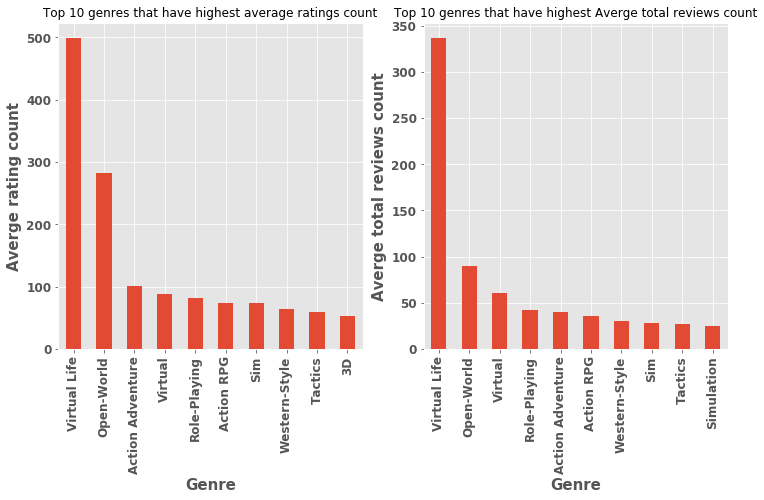

In [31]:
# draw top 10 genres that have highest average ratings count
group_genre = df_genre.groupby('genre')['rating_count'].agg(['count','mean']).sort_values(by='mean',ascending=False)
group_genre = group_genre[group_genre['count']>10] #Filter genre that has less than 10 games

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
group_genre.head(10)['mean'].plot.bar()
plt.xlabel('Genre',fontweight='bold',fontsize=15)
plt.ylabel('Averge rating count',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Top 10 genres that have highest average ratings count',fontsize=12)


# draw top 10 genres that have higest Averge total reviews count
group_genre = df_genre.groupby('genre')['total_review_counts'].agg(['count','mean']).sort_values(by='mean',ascending=False)
group_genre = group_genre[group_genre['count']>10] #Filter genre that has less than 10 games

plt.subplot(1,2,2)
group_genre.head(10)['mean'].plot.bar()
plt.xlabel('Genre',fontweight='bold',fontsize=15)
plt.ylabel('Averge total reviews count',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Top 10 genres that have highest Averge total reviews count',fontsize=12)
plt.savefig('genre_popular.png',bbox_inches = 'tight')

### Developer

In [32]:
# Make a copy of the original dataframe
df_developer = df.copy()
# Split the column the column using '|'
df_developer.developer = df_developer.developer.apply(lambda x: x.split(','))
# i keeps tracks of index
index=0
# save [index, genre] in a nested list
list_ = []
for item in df_developer.developer:
    list_.extend(map(lambda x: [index, x], item))
    index += 1
developer = pd.DataFrame(list_, columns=['index', 'developer'])
df_developer = pd.merge(df_developer.drop('developer', axis=1), developer, how='right', left_index=True, right_on='index')
#df_developer.head()

In [33]:
df_developer.developer.value_counts().head(10)

Hamster                  213
Nintendo                 104
Ratalaika Games           74
Forever Entertainment     62
Ultimate Games            54
Sega                      49
Arc System Works          45
Bandai Namco Games        44
Digerati Distribution     42
Ubisoft                   40
Name: developer, dtype: int64

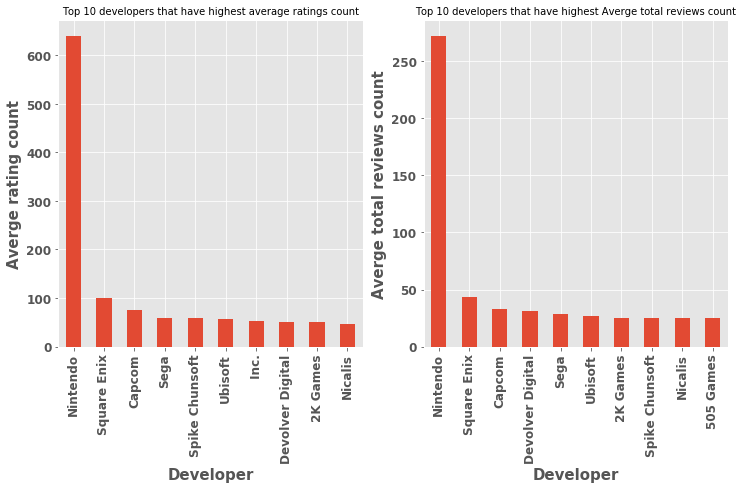

In [34]:
# plot Top 10 developer that have highest average ratings count
group_developer = df_developer.groupby('developer')['rating_count'].agg(['count','mean']).sort_values(by='mean',ascending=False)
group_developer = group_developer[group_developer['count']>10] #Filter developer that has less than 10 games
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
group_developer.head(10)['mean'].plot.bar()
plt.xlabel('Developer',fontweight='bold',fontsize=15)
plt.ylabel('Averge rating count',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Top 10 developers that have highest average ratings count',fontsize=10)

# plot Top 10 developers that have highest Averge total reviews count
group_developer = df_developer.groupby('developer')['total_review_counts'].agg(['count','mean']).sort_values(by='mean',ascending=False)
group_developer = group_developer[group_developer['count']>10] #Filter developer that has less than 10 games
plt.subplot(1,2,2)
group_developer.head(10)['mean'].plot.bar()
plt.xlabel('Developer',fontweight='bold',fontsize=15)
plt.ylabel('Averge total reviews count',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Top 10 developers that have highest Averge total reviews count',fontsize=10)
plt.savefig('developer_popular.png',bbox_inches = 'tight')

### Release Date

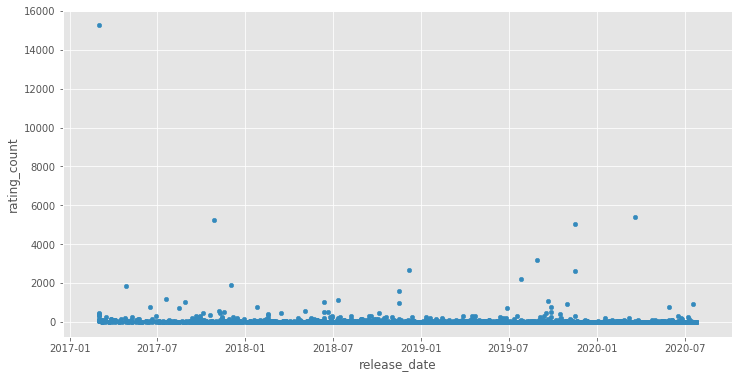

In [35]:
df.plot.scatter(x='release_date',y='rating_count',figsize=(12,6))

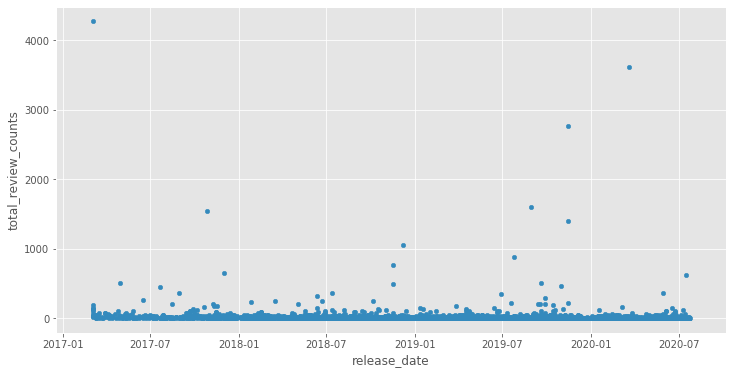

In [36]:
df.plot.scatter(x='release_date',y='total_review_counts',figsize=(12,6))

## Success

### Define Success of a game

Let's decide how to measure if a game is success. Meta_score is the critics' attitude toward the game. User_score is the user's attitude toward the game. In the data cleaning we have already combined them into avg_score. So if the avg_score of a game is high, that means both user and critics love the game. Let's now measure the avg_score of all games.

In [37]:
df[['name','avg_score']].sort_values(by = 'avg_score',ascending = False).head(10)

,name,avg_score
900,Super Mario Odyssey,93.0
1071,The Legend of Zelda: Breath of the Wild,91.5
2008,Divinity: Original Sin II - Definitive Edition,90.0
906,Super Kickers League,90.0
882,Super Smash Bros. Ultimate,89.5
1546,Xenoblade Chronicles: Definitive Edition,89.5
2612,Hollow Knight,89.5
2981,Mario Kart 8 Deluxe,89.0
4037,Bayonetta 2,89.0
1700,Celeste,88.5


The most success game is Super Mario Odyssey following by The Legend of Zelda: Breath of the Wild

### genre

Text(0, 0.5, 'Averge Score')

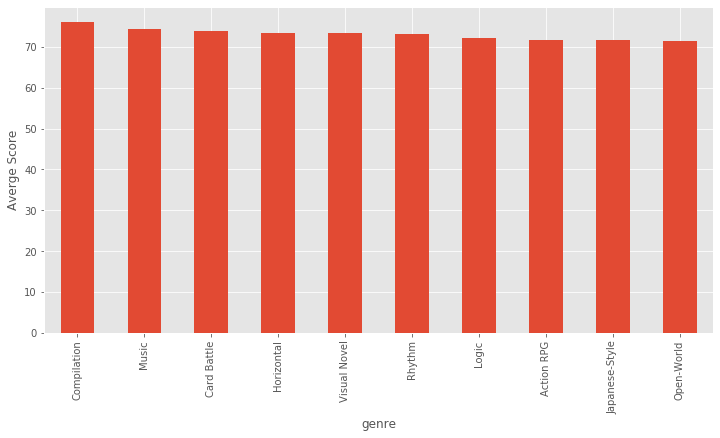

In [38]:
group_genre = df_genre.groupby('genre')['avg_score'].agg(['count','mean']).sort_values(by='mean',ascending=False)
group_genre = group_genre[group_genre['count']>10] #Filter genre that has less than 10 games
plt.figure(figsize=(12,6))
group_genre.head(10)['mean'].plot.bar()
plt.ylabel('Averge Score')

### Developer

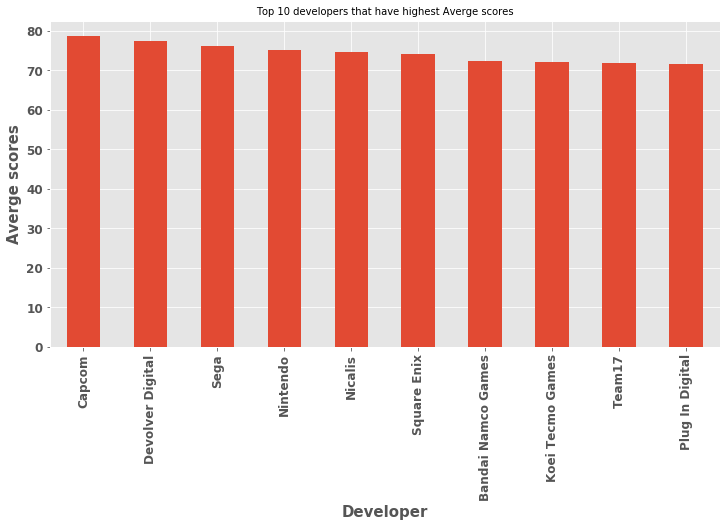

In [56]:
group_developer = df_developer.groupby('developer')['avg_score'].agg(['count','mean']).sort_values(by='mean',ascending=False)
group_developer = group_developer[group_developer['count']>10] #Filter developer that has less than 10 games
plt.figure(figsize=(12,6))
group_developer.head(10)['mean'].plot.bar()
plt.xlabel('Developer',fontweight='bold',fontsize=15)
plt.ylabel('Averge scores',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Top 10 developers that have highest Averge scores',fontsize=10)
plt.savefig('developer_success.png',bbox_inches = 'tight')

### Release Date

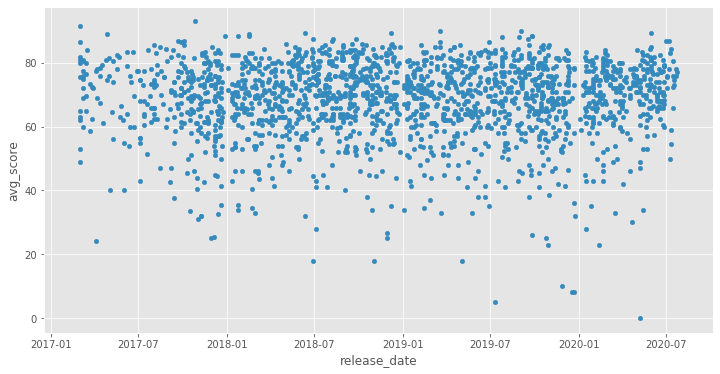

In [40]:
df.plot.scatter(x='release_date',y='avg_score',figsize=(12,6))

## Online Service

5.Nitendo has a paid online service for people to play games together through internet, which game that has this features is the most popular and successful? Is the games which have this feature more popular than those which do not?

6.How to make more people pay for the online service?


In [41]:
df.online.value_counts()

False    3400
True      750
Name: online, dtype: int64

In [42]:
df.columns

Index(['name', 'developer', 'release_date', 'is_on_other_platform',
       'meta_score', 'user_score', 'avg_score', 'rating_count', 'genre',
       'Rating', 'critic_review_count', 'users_review_count',
       'total_review_counts', 'critic_review_attitude',
       'users_review_attitude', 'online'],
      dtype='object')

There are only 750 games which can play online.Let's compare two groups' popularity and success.

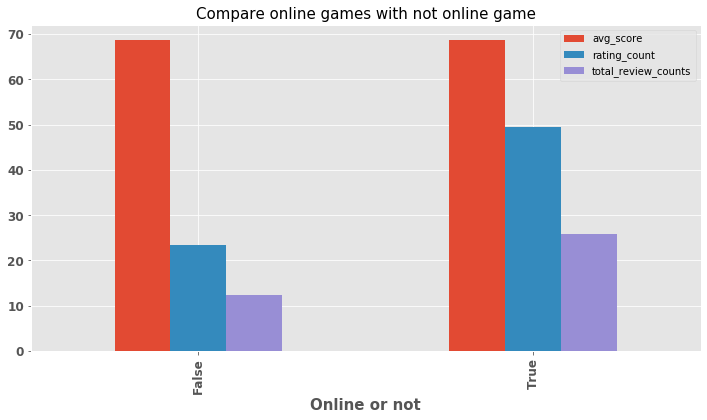

In [43]:
group = df.groupby('online').agg('mean')[['avg_score','rating_count','total_review_counts',]]
group.plot.bar(figsize=(12,6))
plt.xlabel('Online or not',fontweight='bold',fontsize=15)
plt.ylabel('',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Compare online games with not online game',fontsize=15)
plt.savefig('online.png',bbox_inches = 'tight')

In [44]:
from scipy import stats
# Perform two sample t-test to see it the mean of avg_score of two groups are the same
online_group = df[df.online == True]
not_online_group = df[df.online != True]
stats.ttest_ind(online_group['avg_score'].dropna(), not_online_group['avg_score'].dropna())

Ttest_indResult(statistic=-0.0071820668647326665, pvalue=0.9942703347343751)

Check what is the most popular top100 games in each group, and calculate the count of their genres.

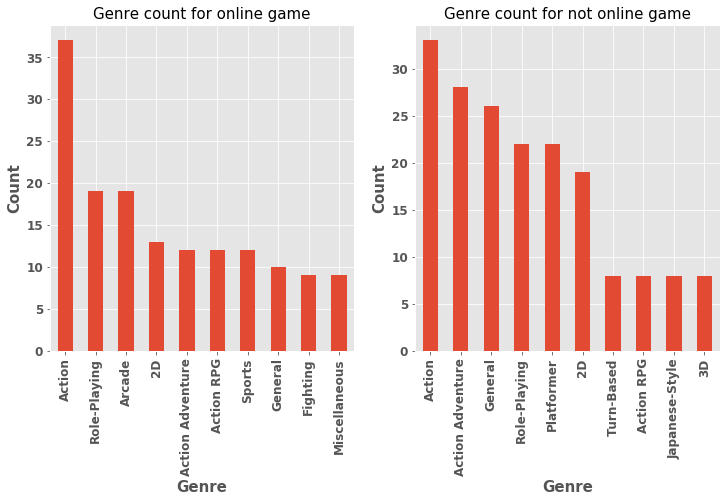

In [45]:
# plot top10 Genre with most count for online game
online_game = df[df['online']==True]
online_game = online_game.sort_values(by='rating_count',ascending = False)[['name']].head(100)
online_game = pd.merge(online_game,df_genre,how='left',on='name')
#online_game = online_game[online_game.avg_score>80]
plt.figsize=(12,6)
plt.subplot(1,2,1)
online_game.genre.value_counts().head(10).plot.bar()
plt.xlabel('Genre',fontweight='bold',fontsize=15)
plt.ylabel('Count',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Genre count for online game',fontsize=15)

# plot top10 Genre with most count for not online game
no_online_game = df[df['online']!=True]
no_online_game = no_online_game.sort_values(by='rating_count',ascending = False)[['name']].head(100)
no_online_game = pd.merge(no_online_game,df_genre,how='left',on='name')
#no_online_game = no_online_game[no_online_game.avg_score>80]
plt.subplot(1,2,2)
no_online_game.genre.value_counts().head(10).plot.bar(figsize=(12,6))
plt.xlabel('Genre',fontweight='bold',fontsize=15)
plt.ylabel('Count',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Genre count for not online game',fontsize=15)
plt.savefig('online1.png',bbox_inches = 'tight')

## Different Platform makes a differece?

* Some games are transfer from other platform such as PS4 and Wii, how is their ratings compared to other platform?

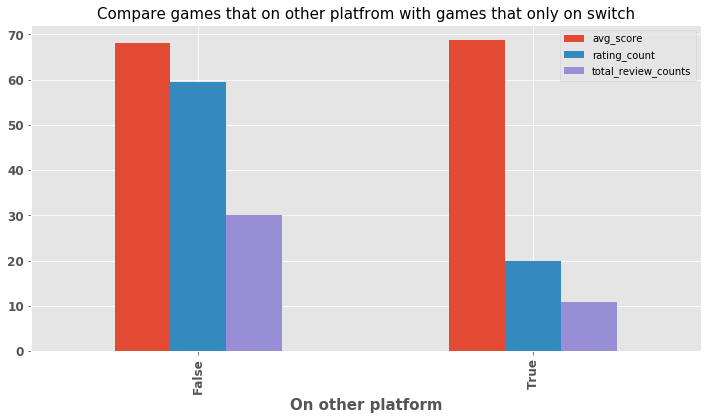

In [46]:
df.groupby('is_on_other_platform').agg('mean')[['avg_score','rating_count','total_review_counts']].plot.bar(figsize=(12,6))
plt.xlabel('On other platform',fontweight='bold',fontsize=15)
plt.xticks(fontweight='bold',fontsize=12)
plt.yticks(fontweight='bold',fontsize=12)
plt.title('Compare games that on other platfrom with games that only on switch',fontsize=15)
plt.savefig('platform.png',bbox_inches = 'tight')

In [47]:
df.groupby('is_on_other_platform').agg(['count'])['total_review_counts']#.plot.bar(figsize=(12,6))

,count
is_on_other_platform,
False,857
True,3293


## Selling Data vs scores a game is successful or not

7.We have best selling game data , is there any difference between the ranking in Metacritic website? Why?

8.What is the relationship between the selling unit and scores in metacritic website?

In [48]:
import seaborn as sns

In [49]:
df[df['name'].isin(["Pokemon: Let's Go, Pikachu!" ,"Pokemon: Let's Go, Eevee!","Pokemon Sword","Pokemon Shield"])]

,name,developer,release_date,is_on_other_platform,meta_score,user_score,avg_score,rating_count,genre,Rating,critic_review_count,users_review_count,total_review_counts,critic_review_attitude,users_review_attitude,online
62,"Pokemon: Let's Go, Pikachu!",Nintendo,2018-11-16,False,79.0,61.0,70.0,1597,"Action RPG,Role-Playing,Trainer",E,92,670,762,"{'Positive': 65, 'Mixed': 19, 'Negative': 0}","{'Positive': 305, 'Mixed': 75, 'Negative': 290}",True
63,"Pokemon: Let's Go, Eevee!",Nintendo,2018-11-16,False,80.0,62.0,71.0,971,"Action RPG,Role-Playing,Trainer",E,86,405,491,"{'Positive': 62, 'Mixed': 15, 'Negative': 1}","{'Positive': 198, 'Mixed': 42, 'Negative': 165}",True
66,Pokemon Sword,Nintendo,2019-11-15,False,80.0,46.0,63.0,5040,"Role-Playing,Trainer",E,94,2664,2758,"{'Positive': 66, 'Mixed': 21, 'Negative': 0}","{'Positive': 778, 'Mixed': 330, 'Negative': 1556}",False
67,Pokemon Shield,Nintendo,2019-11-15,False,80.0,45.0,62.5,2646,"Role-Playing,Trainer",E,96,1296,1392,"{'Positive': 69, 'Mixed': 20, 'Negative': 0}","{'Positive': 404, 'Mixed': 170, 'Negative': 722}",True


In [50]:
# Create datafram that combine Pokemon Sword and Shield ,Pokemon: Let's Go, Pikachu! and Eevee!
df_poke = pd.DataFrame([
                       ["Pokemon: Let's Go, Pikachu! and Let's Go, Eevee!","Nintendo",pd.to_datetime('2018-11-16'),False,79.5,61.5,70.5,1597+971,
                         "Action RPG,Role-Playing,Trainer",'E',92+86,670+405,762+491,{'Positive': 65+62, 'Mixed': 19+15, 'Negative': 1},
                        {'Positive': 305+198, 'Mixed': 75+42, 'Negative': 290+165},True],
                       ["Pokemon Sword and Shield","Nintendo",pd.to_datetime('2019-11-15'),False,80,45.5,62.75,2646+5040,
                         "Role-Playing,Trainer",'E',94+96,2664+1296,2758+1392,{'Positive': 66+69, 'Mixed': 21+20, 'Negative': 0},
                        {'Positive': 778+404, 'Mixed': 330+170, 'Negative': 1556+722},False]
                       ],
                        columns=df.columns)
df_combine = pd.concat([df_poke,df],axis=0)

In [51]:
df_sell = pd.read_csv('switchsell.csv')#.drop('No.',axis = 1)
df_sell.head()

,name,Copies sold in million
0,Mario Kart 8 Deluxe,24.77
1,Super Smash Bros. Ultimate,18.84
2,The Legend of Zelda: Breath of the Wild,17.41
3,Super Mario Odyssey,17.41
4,Pokemon Sword and Shield,17.37


In [52]:
df_withsell = pd.merge(df_sell,df_combine,on = 'name')

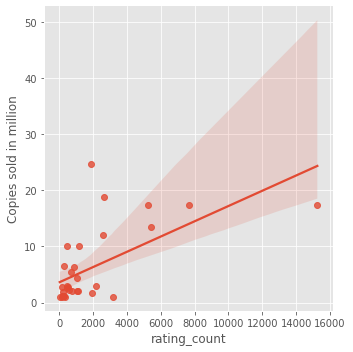

In [53]:
sns.lmplot('rating_count','Copies sold in million', df_withsell)

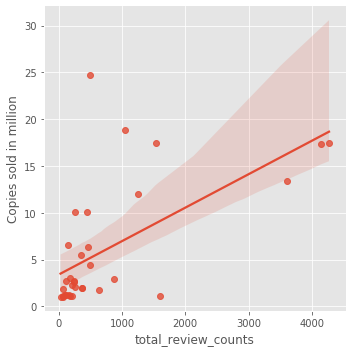

In [54]:
sns.lmplot('total_review_counts','Copies sold in million', df_withsell)

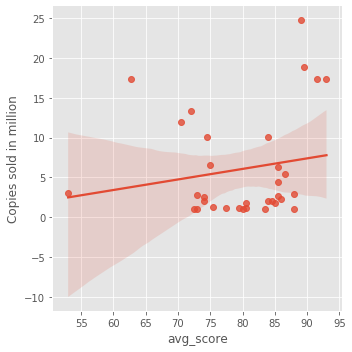

In [55]:
sns.lmplot('avg_score','Copies sold in million', df_withsell)

# Conclusion

* The most popular game genre : Virtual Life, Open-World
* Developer that makes the most popular games: Nintendo, Square Enix, Capcom 
* Nintendo should make more acrade, role-playing, sports game to make more people pay for the online service.
* Games that are transferred from other platform perform bad than games that are only on switch.


# Future Work
* If we are given the selling data, can we predict game selling based on their popularity or success?
* Some games have high user and meta score may because of insufficient rating and reviews, how can we overcome this issue?
* What is the distribution of the release date? Does it have a relationship with games' popularity or success?
* For some specific games, is there any difference between their critic reviews and user reviews?
* Scrap all user review and critic review and do sentiment analysis to see how people actually think of a specific game.